#### In this notebook we will model a sine wave using RNN
***

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [3]:
x = np.linspace(0,50,501)
y = np.sin(x)

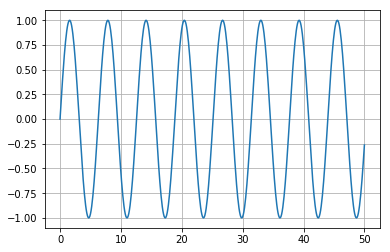

In [6]:
# plotting the sin wave
plt.grid()
plt.plot(x,y)

In [8]:
# making this a dataframe
sin_df = pd.DataFrame(data=y, index=x, columns=['Sine'])

In [11]:
sin_df.head()

,Sine
0.0,0.000000
0.1,0.099833
0.2,0.198669
0.3,0.295520
0.4,0.389418


In [15]:
# now we will split the dataset to train and test
test_percent = 0.1
test_point = test_percent * len(sin_df)

train_set = sin_df.iloc[:int(len(sin_df) - test_point)]
test_set = sin_df.iloc[int(len(sin_df) - test_point):]

In [17]:
train_set.shape, test_set.shape

((450, 1), (51, 1))

In [18]:
# we will scale the y target here as in RNN the output goes back to the neuron as input
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [20]:
scaled_train = scaler.fit_transform(train_set)
scaled_test = scaler.transform(test_set)

In [41]:
# now we will use tensorflow to create a batch generator for training RNN model
from keras.preprocessing.sequence import TimeseriesGenerator

length = 50
batch_size=1
# we will use the TimeSeriesGenerator to generate data for training the model
generator = TimeseriesGenerator(data=scaled_train, targets=scaled_train, length=length,
                               batch_size=batch_size)

In [42]:
len(generator)

400

In [55]:
# contains the first 25 values as x and y= 26th value
generator[0]
# the input is in 3 dimensions,
# hence during model prediction we have to give the input in the same format

(array([[[4.99999116e-01],
         [5.49916225e-01],
         [5.99334579e-01],
         [6.47760405e-01],
         [6.94709850e-01],
         [7.39713809e-01],
         [7.82322618e-01],
         [8.22110545e-01],
         [8.58680040e-01],
         [8.91665714e-01],
         [9.20737985e-01],
         [9.45606372e-01],
         [9.66022399e-01],
         [9.81782075e-01],
         [9.92727935e-01],
         [9.98750612e-01],
         [9.99789928e-01],
         [9.95835500e-01],
         [9.86926839e-01],
         [9.73152957e-01],
         [9.54651478e-01],
         [9.31607263e-01],
         [9.04250562e-01],
         [8.72854714e-01],
         [8.37733417e-01],
         [7.99237589e-01],
         [7.57751870e-01],
         [7.13690771e-01],
         [6.67494535e-01],
         [6.19624741e-01],
         [5.70559686e-01],
         [5.20789614e-01],
         [4.70811810e-01],
         [4.21125636e-01],
         [3.72227539e-01],
         [3.24606094e-01],
         [2.78737119e-01],
 

In [32]:
# we will create the model here
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM

In [44]:
n_features = 1

model = Sequential()

model.add(SimpleRNN(units=50, input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [45]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 50)                2600      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 2,651
Trainable params: 2,651
Non-trainable params: 0
_________________________________________________________________


In [46]:
model.fit_generator(generator, epochs=5)

Epoch 1/5
400/400 [==============================] - 9s 24ms/step - loss: 0.0052
Epoch 2/5
400/400 [==============================] - 9s 23ms/step - loss: 3.3717e-05
Epoch 3/5
400/400 [==============================] - 9s 22ms/step - loss: 7.7794e-04
Epoch 4/5
400/400 [==============================] - 9s 21ms/step - loss: 6.9834e-05
Epoch 5/5
400/400 [==============================] - 9s 23ms/step - loss: 2.0413e-05


In [47]:
losses_df = pd.DataFrame(model.history.history)

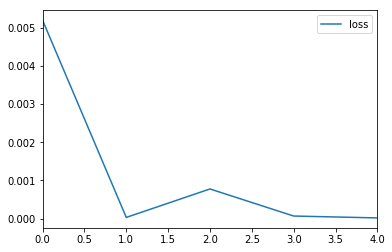

In [49]:
losses_df.plot()

In [91]:
# now evaluate on test data
# in order to get the predictions we have to give the model historical data
# that will be the last data points from our train set
# folowing that we will include our predictions in the train set 
# till all the input points are the predictions

test_predictions = []

# get the last 50 data points
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1,length,1))

In [92]:
for i in range(len(test_set)):
    current_pred = model.predict(current_batch)[0]
    
    test_predictions.append(current_pred)

    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)

In [93]:
test_predictions

[array([0.9336943], dtype=float32),
 array([0.9581292], dtype=float32),
 array([0.97805893], dtype=float32),
 array([0.9957723], dtype=float32),
 array([1.0102737], dtype=float32),
 array([1.0169605], dtype=float32),
 array([1.0164012], dtype=float32),
 array([1.0131549], dtype=float32),
 array([1.0054591], dtype=float32),
 array([0.99117804], dtype=float32),
 array([0.97100323], dtype=float32),
 array([0.9483192], dtype=float32),
 array([0.9213879], dtype=float32),
 array([0.8896997], dtype=float32),
 array([0.85505927], dtype=float32),
 array([0.81711423], dtype=float32),
 array([0.77610064], dtype=float32),
 array([0.7323877], dtype=float32),
 array([0.6869126], dtype=float32),
 array([0.6395856], dtype=float32),
 array([0.58995146], dtype=float32),
 array([0.53984904], dtype=float32),
 array([0.4898057], dtype=float32),
 array([0.43865922], dtype=float32),
 array([0.38826126], dtype=float32),
 array([0.3388362], dtype=float32),
 array([0.2910748], dtype=float32),
 array([0.24537253

In [94]:
# we need to compare test predictions to actual test
true_predictions = scaler.inverse_transform(test_predictions)

In [95]:
len(true_predictions)

51

In [97]:
test_set['predictions'] = true_predictions

/home/deb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


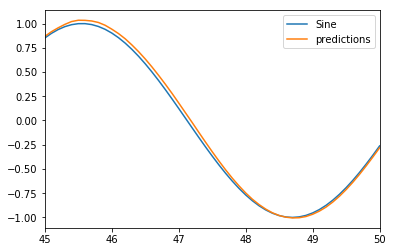

In [99]:
test_set.plot()

In [100]:
from keras.layers import Input

help(Input)

Help on function Input in module keras.engine.input_layer:

Input(shape=None, batch_shape=None, name=None, dtype=None, sparse=False, tensor=None)
    `Input()` is used to instantiate a Keras tensor.
    
    A Keras tensor is a tensor object from the underlying backend
    (Theano, TensorFlow or CNTK), which we augment with certain
    attributes that allow us to build a Keras model
    just by knowing the inputs and outputs of the model.
    
    For instance, if a, b and c are Keras tensors,
    it becomes possible to do:
    `model = Model(input=[a, b], output=c)`
    
    The added Keras attributes are:
        `_keras_shape`: Integer shape tuple propagated
            via Keras-side shape inference.
        `_keras_history`: Last layer applied to the tensor.
            the entire layer graph is retrievable from that layer,
            recursively.
    
    # Arguments
        shape: A shape tuple (integer), not including the batch size.
            For instance, `shape=(32,)` ind